# Cooke triplet optimization

I'm going to try and come up with a better "user interface" for optimization, based on the "textbook" Cooke triplet example from this page:

https://wp.optics.arizona.edu/jsasian/wp-content/uploads/sites/33/2016/03/L20_OPTI517_Cooke_triplet.pdf

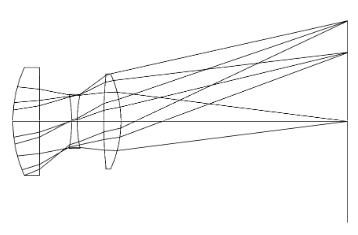

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import time

import opticsRayTrace.rayTraceTools as rtt
import opticsRayTrace.drawing as rtd
import opticsRayTrace.optimize as rto
import opticsRayTrace.analyze as rta

rayTraceTools loaded
drawing loaded
optimize loaded
analyze loaded


I'm going to try identifying the variables, within the surface list, for readability. Then the optimization process can automate bundling the list of variables into a 1-d numeric array for the minimize() function.

In [2]:
surface_list = [
{'surf': 'dummy',
 'dist': 10},

{'surf': 'conic',
  'R': 23.713,
  'dist': 4.831,
  'draw_radius': 10,
  'material': 'N-LAK9',
  'variables': ['R']},

 {'surf': 'conic',
  'R': 7331.288,
  'dist': 5.86,
  'draw_radius': 10,
  'variables': ['R']},

 {'surf': 'conic',
  'R': -24.456,
  'dist': 0.975,
  'draw_radius': 10,
  'material': 'N-SF5',
  'stop': True,
  'variables': ['R']},

 {'surf': 'conic',
  'R': 21.896,
  'dist': 4.822,
  'draw_radius': 10,
  'variables': ['R']},

 {'surf': 'conic',
  'R': 86.759,
  'dist': 3.127,
  'draw_radius': 10,
  'material': 'N-LAK9',
  'variables': ['R']},

 {'surf': 'conic',
  'R': -20.494,
  'dist': 41.10346,
  'draw_radius': 10,
  'variables': ['R']},
  
 {'surf': 'dummy'}
 ]

stop_surface = 4

Prior to optimization, I'll take care of some housekeeping, such as documenting the starting point, ray aiming, and finding convenient diameters for drawing.

0.010020971298217773


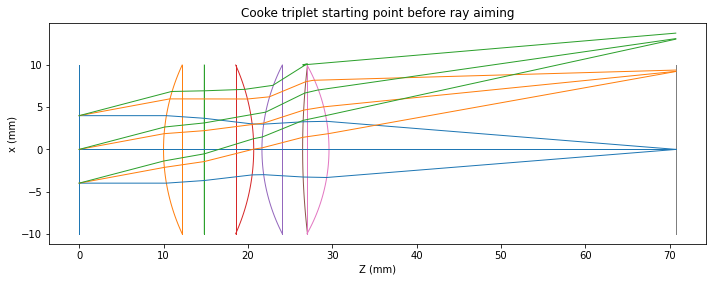

In [3]:
geometry = rtt.build_geometry(surface_list)

wavls = [0.000633]

ray_table = rtt.ray_table_fields_1d(geometry, 15, 3, 8, 3, wavls)

t0 = time.time()
rtt.trace_rays(ray_table, geometry)
print(time.time() - t0)

# now let's see what we've got

axd = rtd.new_plot(axes = ["x"], figsize = (10, 10))
rtd.plot_faces(axd, geometry, linewidth = 1)
rtd.plot_rays(axd, geometry, ray_table, linewidth = 1, color_by = "field")
axd["axs"][0].set_title("Cooke triplet starting point before ray aiming")
plt.show()

The apparent entrance pupil is at the entrance to the system, not where we want it. Now I need to choose values for the pupil shifts. I will say that the rays are correctly "aimed" when the ray bundle for each field angle is centered at the stop surface, i.e., that the squared position of those rays is at a minimum. This suggests a merit function and optimization.

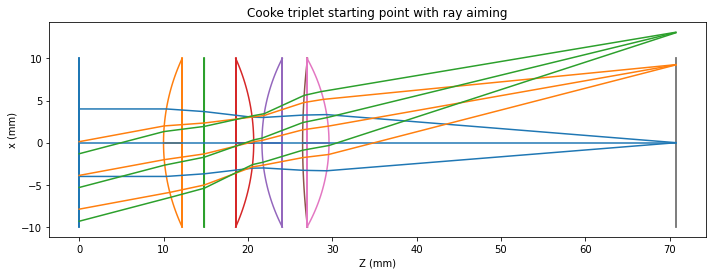

In [4]:
'''
The ray aiming constants are 6 coefficients of a linear transformation applied
to field points. Ray aiming finds values of these coefficients that minimize the
RMS radius of the ray bundle at the stop surface.
'''
aim_consts = rto.ray_aiming(geometry, wavls, True)

'''
Given desired values of the aiming constants, we recompute the starting ray table
and propagate the new rays through the optical system. Note that I haven't
optimized the design yet, but the spot sizes already look smaller. This design
is now closer to the original textbook design.
'''

ray_table = rtt.ray_table_fields_1d(geometry, 15, 3, 8, 3, wavls, aim_consts)

rtt.trace_rays(ray_table, geometry)
axd = rtd.new_plot(axes = ["x"], figsize = (10, 10))
rtd.plot_faces(axd, geometry)
rtd.plot_rays(axd, geometry, ray_table, color_by = 'field')
axd["axs"][0].set_title("Cooke triplet starting point with ray aiming")
plt.show()

One last trimming: I didn't give any radii for drawing the surfaces, and it's hard to visually compare the drawings to the one from the reference, so I created a little script that applies a default to each surface, just big enough to contain the rays, plus a margin. This is purely aesthetic. My program doesn't do anything with the draw radius while ray tracing.

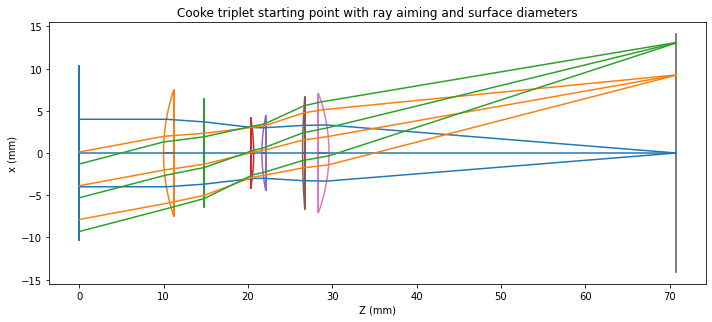

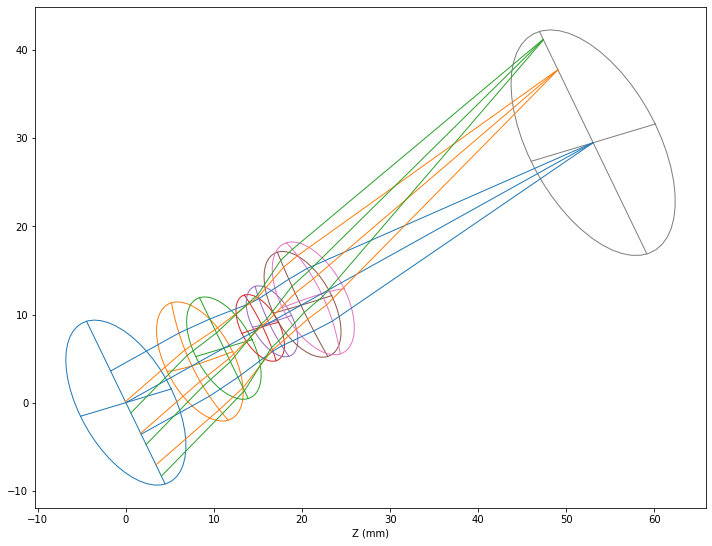

In [5]:
def find_draw_radii(ray_table):
    radius_list = []
    for surf in range(ray_table.shape[0]):
        radius = np.max(np.sqrt(np.sum(ray_table[surf, :, 0, :-1]**2, axis = 1)))
        radius_list.append(radius)
    return np.array(radius_list)

def apply_draw_radii(geometry, ray_table, margin):
    radii = find_draw_radii(ray_table) + margin
    for i in range(len(geometry)):
        geometry[i]['draw_radius'] = radii[i]
        
apply_draw_radii(geometry, ray_table, 1)
        
axd = rtd.new_plot(axes = ["x"], figsize = (10, 10))
rtd.plot_faces(axd, geometry)
rtd.plot_rays(axd, geometry, ray_table, color_by = "field")
axd["axs"][0].set_title("Cooke triplet starting point with ray aiming and surface diameters")
plt.show()

axd = rtd.new_plot(axes = ["3d"], figsize = (10, 10))
rtd.plot_faces(axd, geometry, linewidth = 1)
rtd.plot_rays(axd, geometry, ray_table, linewidth = 1, color_by = "field")
plt.show()

I'm going to define a really basic merit function, which will be the sum of RMS spot sizes. For this purpose, the rays have to be separated by field, so that each field gets its own RMS value.

In [6]:
starting_params = rto.get_values(rto.get_variable_list(surface_list))
starting_params

array([  23.713, 7331.288,  -24.456,   21.896,   86.759,  -20.494])

In [7]:
def merit_focus_quality(params, ray_table, surface_list):
    '''
    Compute the merit function.

    Always do a merit_prepare(). This is what inserts the new parameters into the
    surface list, creates a new geometry, and traces the rays. After this function
    runs, the ray table and geometry reflect the new parameters. Here, we don't
    do anything with the geometry, but your merit function could, if you want to
    impose constraints on the design parameters.
    '''
    geometry = rto.merit_prepare(params, ray_table, surface_list)

    '''
    In this case the merit function is the RMS average of the individual RMS
    spot radii for the individual fields. First it gets a list of RMS spot radii
    for the fields, then combines them into a single value.
    '''
    
    rmsa = rta.rms_by_field_radial(ray_table)
    merit = np.sqrt(np.average(rmsa**2))

    return merit


In [8]:
ray_table = rtt.ray_table_fields_rings(geometry, 15, 3, 8, 3, wavls, aim_consts)

In [9]:
result = minimize(merit_focus_quality, starting_params, (ray_table, surface_list))
result['x']

array([  17.95433219, 7331.26518116,  -30.06012169,   17.24055106,
        139.56974633,  -31.14539331])

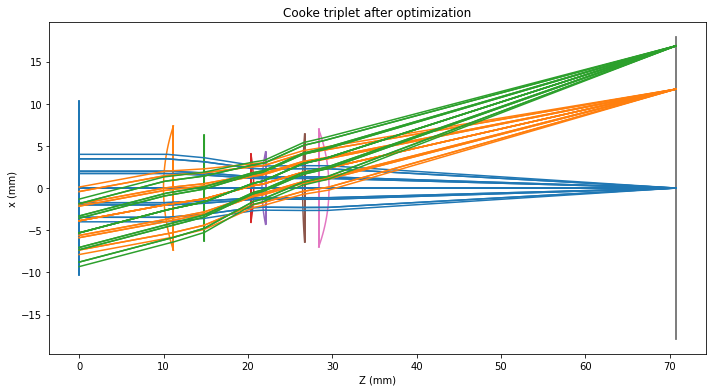

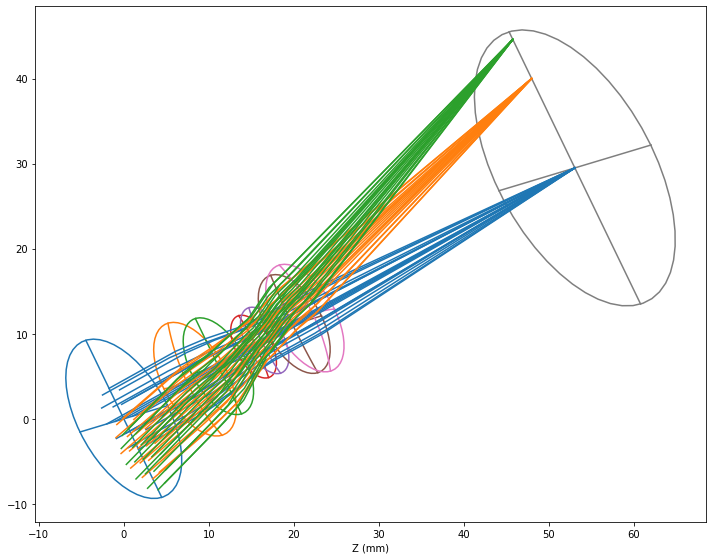

In [10]:
apply_draw_radii(geometry, ray_table, 1)

axd = rtd.new_plot(axes = ["x"], figsize = (10, 10))
rtd.plot_faces(axd, geometry)
rtd.plot_rays(axd, geometry, ray_table, color_by = "field")
axd["axs"][0].set_title("Cooke triplet after optimization")
plt.show()

axd = rtd.new_plot(axes = ["3d"], figsize = (10, 10))
rtd.plot_faces(axd, geometry)
rtd.plot_rays(axd, geometry, ray_table, color_by = "field")

In [12]:
import cProfile
import pstats

In [13]:
ray_table = rtt.ray_table_fields_rings(geometry, 15, 10, 8, 10, wavls, aim_consts)
cProfile.run('merit_focus_quality(starting_params, ray_table, surface_list)', 'merit_focus_quality_profile')

In [14]:
p = pstats.Stats('merit_focus_quality_profile')
p.sort_stats('cumulative').print_stats(10)

Fri Aug 23 20:57:37 2024    merit_focus_quality_profile

         1610 function calls in 0.018 seconds

   Ordered by: cumulative time
   List reduced from 72 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.018    0.018 {built-in method builtins.exec}
        1    0.000    0.000    0.018    0.018 <string>:1(<module>)
        1    0.000    0.000    0.018    0.018 C:\Users\Spatt\AppData\Local\Temp\ipykernel_14656\3156857341.py:1(merit_focus_quality)
        1    0.000    0.000    0.017    0.017 C:\Users\Spatt\Dropbox\gitRepos\opticsRayTrace\src\opticsRayTrace\optimize.py:56(merit_prepare)
        1    0.000    0.000    0.017    0.017 C:\Users\Spatt\Dropbox\gitRepos\opticsRayTrace\src\opticsRayTrace\rayTraceTools.py:666(trace_rays)
        6    0.004    0.001    0.016    0.003 C:\Users\Spatt\Dropbox\gitRepos\opticsRayTrace\src\opticsRayTrace\rayTraceTools.py:451(propagate_conic_surface)
      152    0.